In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils
import torch.autograd as autograd

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Hyperparameters**

In [2]:
class Para():
    def __init__(self):
        self.latent_dim = 10 # latent space dimention
        self.img_shape = (1, 28, 28) # image shape (1x28x28 for MNIST)
        self.generator_path = 'G_l10.pth' # pre-trained generator path
        self.discriminator_path = 'D_l10.pth' # pre-trained discriminator path
        self.batch_size = 25 # batch size for visualization
        
opt = Para()

**Network architectures**

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

**Load networks**

In [4]:
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

**Generator and discriminator visualization**

In [49]:
def vis(y, nrow, title='figure'):
    imgs = torchvision.utils.make_grid(y, nrow=nrow, padding=0, normalize=True)

    if cuda:
        plt.imshow(imgs.permute(1, 2, 0).cpu())
    else:
        plt.imshow(imgs.permute(1, 2, 0))
    plt.title(title)
    plt.show()   

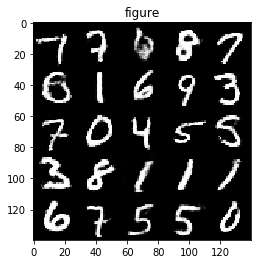

In [50]:
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim)))) # latend variables

with torch.no_grad():
    generated_imgs = generator(z) # generate images
    validity = discriminator(generated_imgs) # discriminator validaty

vis(generated_imgs, nrow=int(np.sqrt(opt.batch_size)))

**GD**

$$\min_uJ(u)=\frac{1}{2}\|G(u)-y\|_2^2$$
$$u_{k+1}=u_k-\alpha_kDJ(u)$$

In [25]:
u_gt = Variable(Tensor(np.random.normal(0, 1, (5, opt.latent_dim)))) # ground truth u
with torch.no_grad():
    y = generator(u_gt) # generated y from u_gt

torch.Size([5, 10])
torch.Size([5, 1, 28, 28])


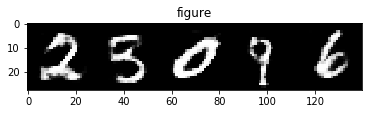

In [26]:
# Visualization of u_gt and y
print(u_gt.shape)
print(y.shape)
vis(y, nrow=5)

[0/40000] tensor(2.4455, device='cuda:0', grad_fn=<MseLossBackward>)
[500/40000] tensor(0.4261, device='cuda:0', grad_fn=<MseLossBackward>)
[1000/40000] tensor(0.3715, device='cuda:0', grad_fn=<MseLossBackward>)
[1500/40000] tensor(0.3036, device='cuda:0', grad_fn=<MseLossBackward>)
[2000/40000] tensor(0.2782, device='cuda:0', grad_fn=<MseLossBackward>)
[2500/40000] tensor(0.2638, device='cuda:0', grad_fn=<MseLossBackward>)
[3000/40000] tensor(0.2545, device='cuda:0', grad_fn=<MseLossBackward>)
[3500/40000] tensor(0.2470, device='cuda:0', grad_fn=<MseLossBackward>)
[4000/40000] tensor(0.2410, device='cuda:0', grad_fn=<MseLossBackward>)
[4500/40000] tensor(0.2362, device='cuda:0', grad_fn=<MseLossBackward>)
[5000/40000] tensor(0.2319, device='cuda:0', grad_fn=<MseLossBackward>)
[5500/40000] tensor(0.2282, device='cuda:0', grad_fn=<MseLossBackward>)
[6000/40000] tensor(0.2245, device='cuda:0', grad_fn=<MseLossBackward>)
[6500/40000] tensor(0.2207, device='cuda:0', grad_fn=<MseLossBackwar

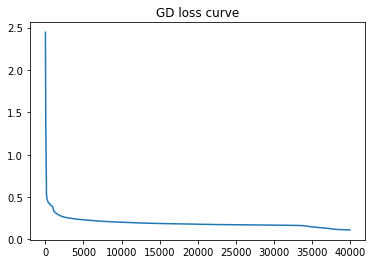

In [27]:
# GD
loss = nn.MSELoss()
u_hat = Variable(Tensor(np.random.normal(0, 0.2, (5, opt.latent_dim))), requires_grad=True)
u_0 = u_hat
alpha = 5e-3
epoch = 40000

l = []
for i in range(epoch):
    l.append(loss(generator(u_hat), y).item())
    if i % 500 == 0:
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat), y))
    grad = autograd.grad(outputs=loss(generator(u_hat), y), inputs=u_hat)[0]
    u_hat = u_hat - alpha * grad

plt.plot(l)
plt.title('GD loss curve')
plt.show()

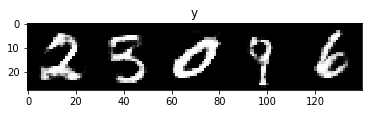

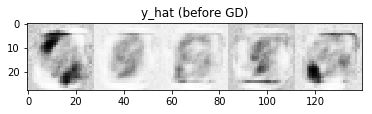

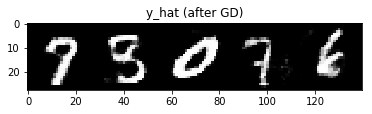

In [28]:
# Visualization of y_hat and y
vis(y, nrow=5, title='y')

with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0, nrow=5, title='y_hat (before GD)')
vis(y_hat, nrow=5, title='y_hat (after GD)')

**Noise model $y=G(u)+\eta$**

We have prior $u\sim\mathcal(m,I)$ and noise model $\eta\sim\mathcal(0,a\cdot I)$. Using Andrew's notations we will have:
$$\min_uJ(u)=\frac{1}{2}\|G(u)-y\|_{a\cdot I}^2+\frac{1}{2}\|u-m\|_{I}^2=\frac{1}{2a}\|G(u)-y\|_2^2+\frac{1}{2}\|u-m\|_2^2$$
$$u_{k+1}=u_k-\alpha_kDJ(u)$$

In [84]:
a = 0.2
u_gt = Variable(Tensor(np.random.normal(0, 1, (5, opt.latent_dim)))) # ground truth u
eta = Variable(Tensor(np.random.normal(0, a, (5, *opt.img_shape)))) # noise
m = Tensor(np.zeros((5, opt.latent_dim)))
with torch.no_grad():
    y = generator(u_gt) + eta # generated y from u_gt
    y_gt = generator(u_gt)

torch.Size([5, 10])
torch.Size([5, 1, 28, 28])


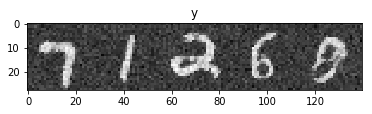

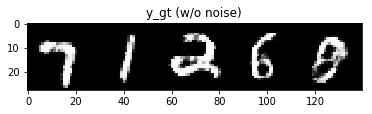

In [85]:
# Visualization of u_gt and y
print(u_gt.shape)
print(y.shape)
vis(y, nrow=5, title='y')
vis(y_gt, nrow=5, title='y_gt (w/o noise)')

[0/40000] tensor(2.1190, device='cuda:0', grad_fn=<AddBackward0>)
[500/40000] tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)
[1000/40000] tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)
[1500/40000] tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)
[2000/40000] tensor(0.3062, device='cuda:0', grad_fn=<AddBackward0>)
[2500/40000] tensor(0.2534, device='cuda:0', grad_fn=<AddBackward0>)
[3000/40000] tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)
[3500/40000] tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)
[4000/40000] tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)
[4500/40000] tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)
[5000/40000] tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)
[5500/40000] tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)
[6000/40000] tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)
[6500/40000] tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)
[7000/40000] tensor(0.1343, device='cu

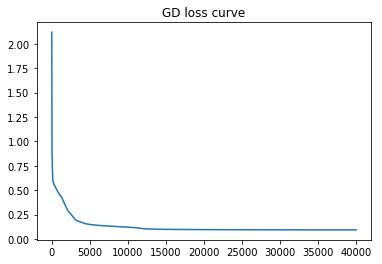

In [87]:
# GD with noise
loss = nn.MSELoss()
u_hat = Variable(Tensor(np.random.normal(0, 0.2, (5, opt.latent_dim))), requires_grad=True)
u_0 = u_hat
alpha = 5e-3
epoch = 40000

l = []
for i in range(epoch):
    l.append((loss(generator(u_hat), y) + a*loss(u_hat, m)).item())
    if i % 500 == 0:
        print('['+str(i)+'/'+str(epoch)+']', loss(generator(u_hat), y) + a*loss(u_hat, m))
    grad = autograd.grad(outputs=loss(generator(u_hat), y) + a*loss(u_hat, m), inputs=u_hat)[0]
    u_hat = u_hat - alpha * grad

plt.plot(l)
plt.title('GD loss curve')
plt.show()

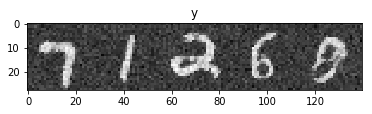

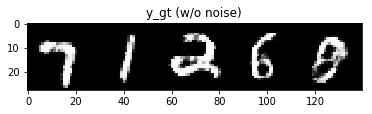

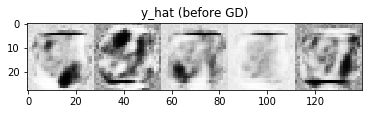

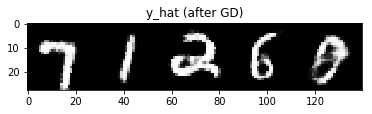

In [88]:
# Visualization of y_hat and y
vis(y, nrow=5, title='y')
vis(y_gt, nrow=5, title='y_gt (w/o noise)')
with torch.no_grad():
    y_hat = generator(u_hat)
    y_hat_0 = generator(u_0)
vis(y_hat_0, nrow=5, title='y_hat (before GD)')
vis(y_hat, nrow=5, title='y_hat (after GD)')